# Exploring the differences in frequency of multiscale extreme precipitation events using GPM

In [6]:
%load_ext autoreload
%autoreload 2
import xarray as xr
import numpy as np
import pandas as pd
from scipy.stats import binned_statistic, binned_statistic_2d
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from src.plotting import *
from src.configs import *
from src.regions import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


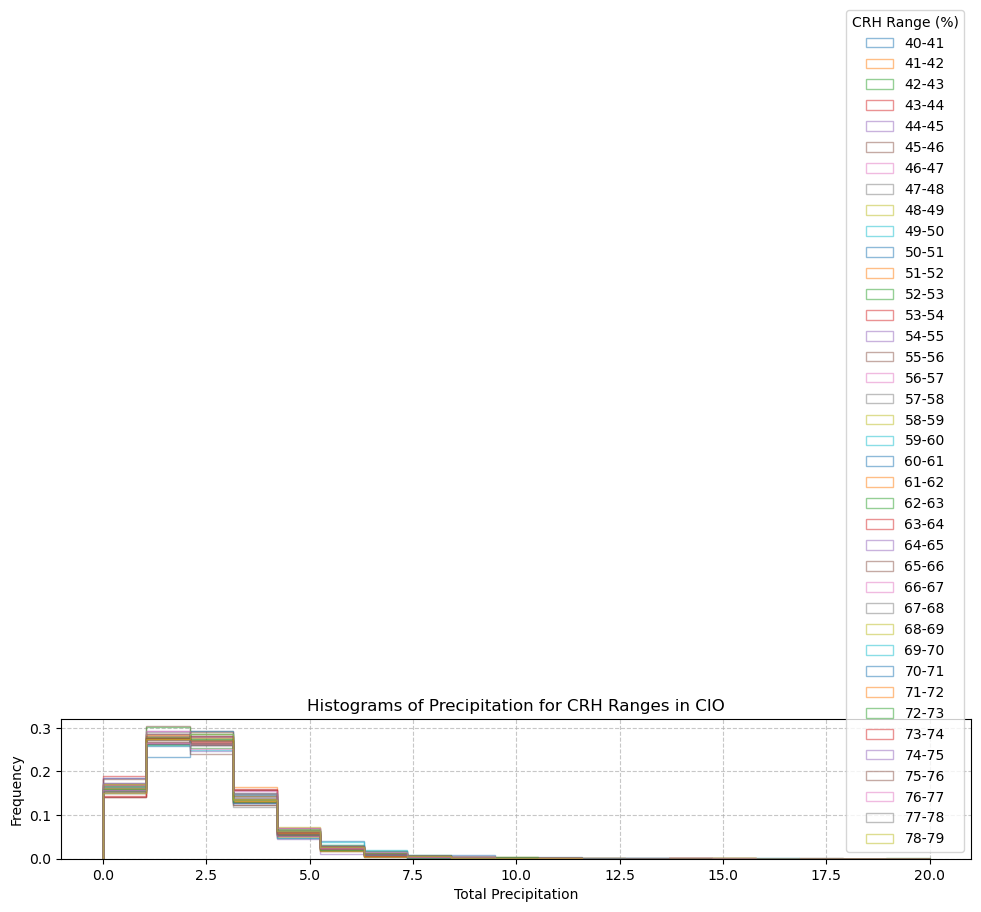

In [49]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Assuming these functions are defined elsewhere
# from your_module import cio_region, load_pf_pc, load_pf_crh

def plot_pr_histograms_by_crh(crh_bins, region):
    """
    Plots histograms of precipitation for specified CRH ranges.

    Parameters:
    - crh_bins: List of CRH bin edges (e.g., [60, 70, 80]).
    - region: Region object with a 'name' attribute.
    """
    # Initialize the plot
    fig, ax = plt.subplots(figsize=(10, 6))

    # Define labels for each CRH range
    labels = [f'{crh_bins[i]}-{crh_bins[i+1]}' for i in range(len(crh_bins)-1)]

    # Load data once outside the loop for efficiency
    pf_df = load_pf_pc(region.name)
    crh_data = load_pf_crh(region.name)['crh']
    pr = pf_df['total_precip']/pf_df['num_pixels']

    # Ensure that 'pr' and 'crh_data' have the same length
    if len(pr) != len(crh_data):
        raise ValueError("Length of 'pr' and 'crh_data' must be the same.")

    # Iterate over CRH bins and plot histograms
    for i in range(len(crh_bins)-1):
        lower = crh_bins[i]
        upper = crh_bins[i+1]

        # Create a boolean mask for the current CRH range
        mask = (crh_data >= lower) & (crh_data < upper)

        # Apply the mask to 'pr' to get precipitation values within the CRH range
        pr_subset = pr[mask]

        # Plot histogram for the current CRH range
        ax.hist(pr_subset, bins=np.linspace(0, 20, 20), alpha=0.5, label=labels[i], histtype='step', density=True)

    # Customize the plot
    ax.set_xlabel('Total Precipitation')
    ax.set_ylabel('Frequency')
    ax.set_title(f'Histograms of Precipitation for CRH Ranges in {region.name}')
    ax.legend(title='CRH Range (%)')
    ax.grid(True, linestyle='--', alpha=0.7)

    # Show the plot
    plt.tight_layout()
    plt.show()

# Example Usage:
# Define CRH bins
crh_bins = np.arange(40, 80, 1)

# Get the region object (Assuming cio_region() returns an object with a 'name' attribute)
region = cio_region()

# Plot the histograms
plot_pr_histograms_by_crh(crh_bins, region)

In [39]:
bin_pfs

0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
        ... 
50534    NaN
50535    NaN
50536    NaN
50537    NaN
50538    NaN
Name: crh, Length: 50539, dtype: category
Categories (99, interval[float64, right]): [(60.0, 60.1] < (60.1, 60.2] < (60.2, 60.3] < (60.3, 60.4] ... (69.5, 69.6] < (69.6, 69.7] < (69.7, 69.8] < (69.8, 69.9]]

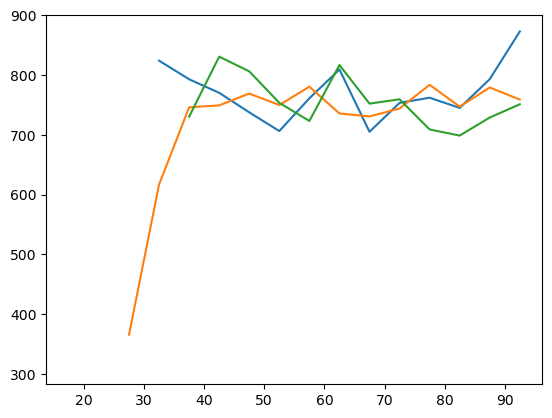

In [20]:
# loop over regions
fig, ax = plt.subplots()
regions = [cio_region(), wmp_region(), afc_region()]

for region in regions:
    pf_df = load_pf_pc(region.name)

    pr = pf_df['total_precip']
    crh = load_pf_crh(region.name)['crh']

    crh_bins = np.arange(0,100, 5)
    mean_pr, bin_edges, _ = binned_statistic(crh, pr, bins=crh_bins)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    ax.plot(bin_centers, mean_pr, label=region.name)




In [15]:
bin_edges

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
       52., 53., 54., 55., 56., 57., 58., 59., 60., 61., 62., 63., 64.,
       65., 66., 67., 68., 69., 70., 71., 72., 73., 74., 75., 76., 77.,
       78., 79., 80., 81., 82., 83., 84., 85., 86., 87., 88., 89., 90.,
       91., 92., 93., 94., 95., 96., 97., 98., 99.])

In [146]:
R = np.sqrt(pf_database.pc1**2 + pf_database.pc2**2)
theta = np.arctan2(pf_database.pc2, pf_database.pc1)

Text(0.5, 1.0, 'CIO')

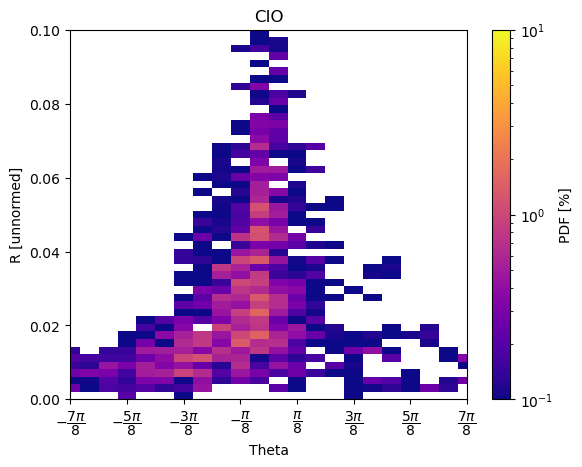

In [147]:
fig, ax = plt.subplots()
R_bins = np.linspace(0,0.1, 50)
theta_bins = np.linspace(-np.pi, np.pi, 25)
hist = binned_statistic_2d(R, theta, None, bins=[R_bins, theta_bins], statistic='count').statistic
hist = (hist/hist.sum())*100 # convert to PDF in percent
R_midpoints = (R_bins[1:] + R_bins[:-1])/2
theta_midpoints = (theta_bins[1:] + theta_bins[:-1])/2

x_mesh, y_mesh = np.meshgrid(theta_midpoints, R_midpoints)
cmap = plt.cm.plasma
norm = colors.LogNorm(vmin=1e-1, vmax=1e1)
c = ax.pcolormesh(x_mesh, y_mesh, hist, norm=norm, cmap=cmap)
cb = fig.colorbar(c)
cb.ax.set_ylabel('PDF [%]')
ax.set_xlabel('Theta')
ax.set_ylabel('R [unnormed]')
ax = label_xaxis_theta(ax)
ax.set_title(region.name)

Now we examine how the distribution looks for extreme events

In [163]:
pr = (pf_database.total_precip/pf_database.num_pixels)
pr_thresh = pr.quantile(0.90)
epe_id = (pr >= pr_thresh)
print(f'Extreme Precip threshold set at {pr_thresh:0.2f} mm/hr')

Extreme Precip threshold set at 4.33 mm/hr


6076.0


Text(0.5, 1.0, 'WMP PDF of Extreme Events')

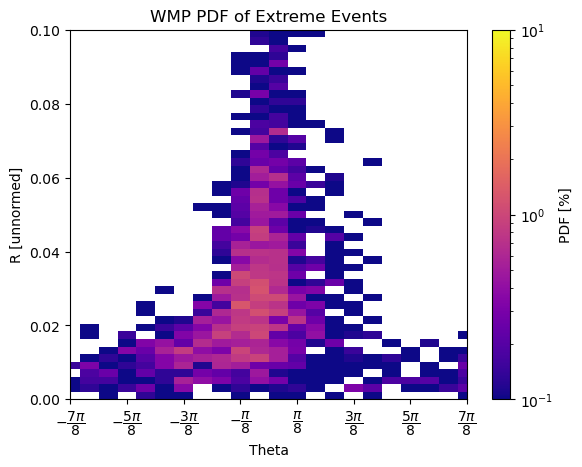

In [164]:
epe_pfs = pf_database.where(epe_id).dropna()
R = np.sqrt(epe_pfs.pc1**2 + epe_pfs.pc2**2)
theta = np.arctan2(epe_pfs.pc2, epe_pfs.pc1)
fig, ax = plt.subplots()

R_bins = np.linspace(0,0.1, 50)
theta_bins = np.linspace(-np.pi, np.pi, 25)
hist = binned_statistic_2d(R, theta, None, bins=[R_bins, theta_bins], statistic='count').statistic
print(hist.sum())
hist = (hist/hist.sum())*100 # convert to PDF in percent
R_midpoints = (R_bins[1:] + R_bins[:-1])/2
theta_midpoints = (theta_bins[1:] + theta_bins[:-1])/2

x_mesh, y_mesh = np.meshgrid(theta_midpoints, R_midpoints)
cmap = plt.cm.plasma
norm = colors.LogNorm(vmin=1e-1, vmax=1e1)
c = ax.pcolormesh(x_mesh, y_mesh, hist, norm=norm, cmap=cmap)
cb = fig.colorbar(c)
cb.ax.set_ylabel('PDF [%]')
ax.set_xlabel('Theta')
ax.set_ylabel('R [unnormed]')
ax = label_xaxis_theta(ax)
ax.set_title(f'{region.name} PDF of Extreme Events')

/var/folders/1t/6drgwyc17q12xmq4h7m454vw0000gn/T/ipykernel_82662/772096744.py:22: RuntimeWarning: invalid value encountered in divide
  prob = (hist/num_epes) * 100
/var/folders/1t/6drgwyc17q12xmq4h7m454vw0000gn/T/ipykernel_82662/772096744.py:22: RuntimeWarning: invalid value encountered in divide
  prob = (hist/num_epes) * 100
/var/folders/1t/6drgwyc17q12xmq4h7m454vw0000gn/T/ipykernel_82662/772096744.py:22: RuntimeWarning: invalid value encountered in divide
  prob = (hist/num_epes) * 100
/var/folders/1t/6drgwyc17q12xmq4h7m454vw0000gn/T/ipykernel_82662/772096744.py:22: RuntimeWarning: invalid value encountered in divide
  prob = (hist/num_epes) * 100


Text(0.5, 0.98, 'WMP')

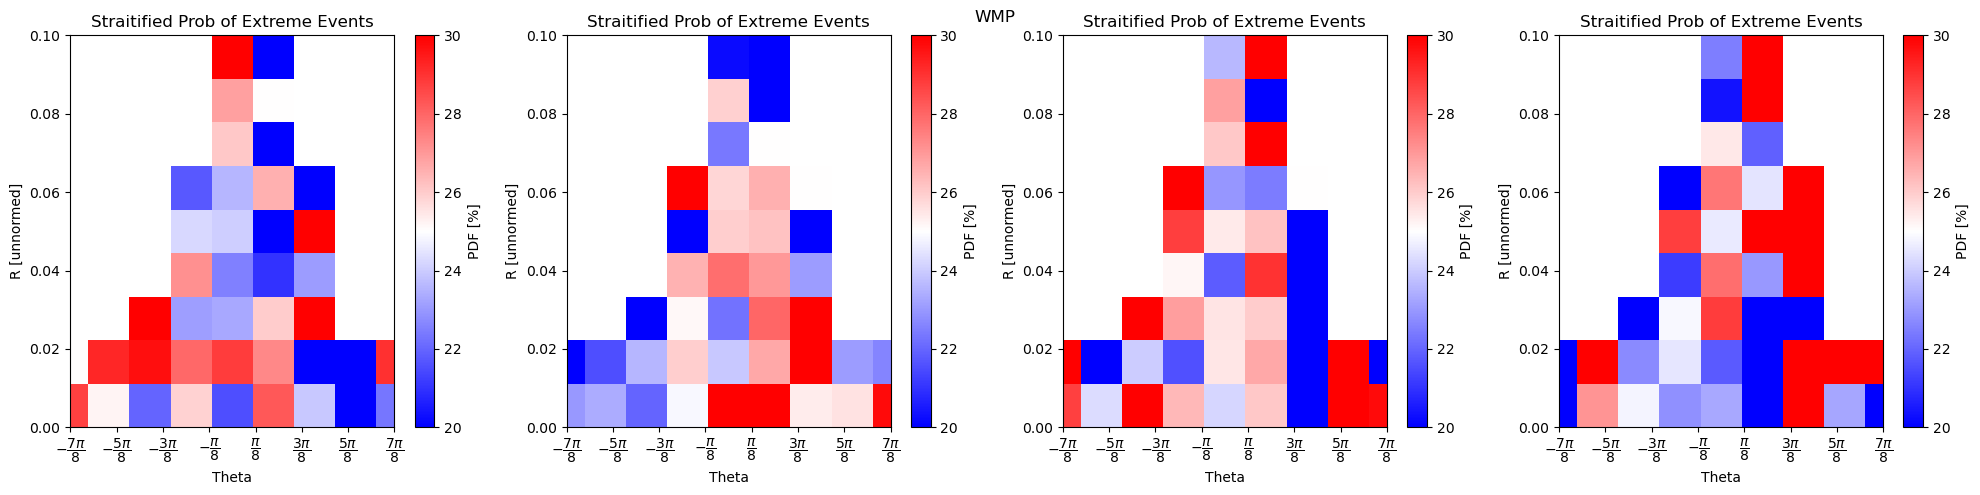

In [172]:
fig, axs = plt.subplots(ncols=4, figsize=(20,5))
epe_pfs = pf_database.where(epe_id).dropna()
R = np.sqrt(epe_pfs.pc1**2 + epe_pfs.pc2**2)
theta = np.arctan2(epe_pfs.pc2, epe_pfs.pc1)
R_bins = np.linspace(0,0.1, 10)
theta_bins = np.linspace(-np.pi, np.pi, 10)
num_epes = binned_statistic_2d(R, theta, None, bins=[R_bins, theta_bins], statistic='count').statistic

# choose metric to stratify by 
org = epe_pfs.total_precip
epe_pfs['org'] = org
for i, ax in enumerate(axs.ravel()):

    # how we look 
    quad_id = (org.quantile(i*0.25)<org) & (org<=org.quantile((i+1)*0.25))
    quad_df = epe_pfs.where(quad_id).dropna()

    quad_R = np.sqrt(quad_df.pc1**2 + quad_df.pc2**2)
    quad_theta = np.arctan2(quad_df.pc2, quad_df.pc1)
    quad_org = quad_df.org
    hist = binned_statistic_2d(quad_R, quad_theta, None, bins=[R_bins, theta_bins], statistic='count').statistic
    prob = (hist/num_epes) * 100
    R_midpoints = (R_bins[1:] + R_bins[:-1])/2
    theta_midpoints = (theta_bins[1:] + theta_bins[:-1])/2

    x_mesh, y_mesh = np.meshgrid(theta_midpoints, R_midpoints)
    cmap = plt.cm.bwr
    norm = colors.TwoSlopeNorm(vmin=20, vcenter=25, vmax=30)
    c = ax.pcolormesh(x_mesh, y_mesh, prob, norm=norm, cmap=cmap)
    cb = fig.colorbar(c)
    cb.ax.set_ylabel('PDF [%]')
    ax.set_xlabel('Theta')
    ax.set_ylabel('R [unnormed]')
    ax = label_xaxis_theta(ax)
    ax.set_title('Straitified Prob of Extreme Events')
fig.tight_layout()
fig.suptitle(region.name)